# Graph Analysis Script
This script will contain the following analyses:
* Spectral Graph Partitioning
* Node Degree Centrality Analysis
* Hierarchy Index Calculation
* Rich Club Coefficient Calculation
* Triangulative Potential Analysis

## Creating the required environment (skip if already done)

Running the following cell will create a file graphs.yml that can be used to setup a conda environment containing the required packages. If you already downloaded the file from my GitHub, skip the next cell and create the env directly from it.

In [ ]:
%%writefile graphs.yml
name: graphs
channels:
  - conda-forge
  - defaults
dependencies:
  - python=3.6
  - jupyter
  - imageio
  - imageio-ffmpeg
  - matplotlib
  - scikit-image
  - opencv
  - networkx
  - pandas
  - statsmodels

### Environment Creation
To create the environment, open the terminal, go to the directory where you stored the graphs.yml file (the directory of the notebook) and type
conda env create -f graphs.yml
After running this command you have to activate the environment (Linux/MacOS: conda activate graphs, Windows: activate graphs) and then reopen the notebook in that environment.

### Additional Imports:
* To calculate the Rich Club coefficient (particularly the random degree distribution graphs), the package random_graph needs to be imported in the terminal by typing ``` pip install git+https://github.com/jamesross2/random_graph ```


In [1]:
import os
import cv2
import json
import numpy as np
import re
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import glob
import scipy.cluster.vq as clusters
import scipy.sparse as sparse
import warnings
import random_graph
warnings.simplefilter(action='ignore', category=FutureWarning)

from scipy.special import binom as nchoosek
from sklearn.preprocessing import normalize
from pandas.plotting import autocorrelation_plot as AC_plot 
from statsmodels.graphics import tsaplots
from statsmodels.tsa.stattools import acf
from skimage.filters import gaussian
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1 import make_axes_locatable, axes_size
from matplotlib import gridspec


OG_DATA_PATH = './'
GIT_DATA_PATH = './Data Exploration/'
GIT_PROCESSED_DATA_PATH = './Results/'
GIT_GRAPH_PATH = './Results/Graphs/'
RESSOURCES_PATH = './Ressources/'

# Reset the Datapath since the data is not yet on Git, comment out if data is on Git 
DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Data Exploration/'

PROCESSED_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/'
GRAPH_DATA_PATH = '/Volumes/EXTENSION/Uni/Study Project/Results/Graphs/'
# Getting the Folder without hidden files in ascending order 
DATA_FOLDER = sorted([f for f in os.listdir(DATA_PATH) if not f.startswith('.')], key=str.lower)
PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_PROCESSED_DATA_FOLDER = sorted([f for f in os.listdir(GIT_PROCESSED_DATA_PATH) if not f.startswith('.')], key=str.lower)
GIT_GRAPH_FOLDER = sorted([f for f in os.listdir(GIT_GRAPH_PATH) if not f.startswith('.')], key=str.lower)

#houselist 
house_file = RESSOURCES_PATH + 'building_collider_list.csv'
try:
    houselist = pd.read_csv(house_file)
except:
    print('HouseList could not be loaded!')
    
    
fontsize = 20

green = [0.40,0.80,0.42]
blue = [0.27,0.38,0.99]
grey = [0.75,0.75,0.75]

# implement parula color map scheme from matlab 
cm_data = [[0.2081, 0.1663, 0.5292], [0.2116238095, 0.1897809524, 0.5776761905], 
 [0.212252381, 0.2137714286, 0.6269714286], [0.2081, 0.2386, 0.6770857143], 
 [0.1959047619, 0.2644571429, 0.7279], [0.1707285714, 0.2919380952, 
  0.779247619], [0.1252714286, 0.3242428571, 0.8302714286], 
 [0.0591333333, 0.3598333333, 0.8683333333], [0.0116952381, 0.3875095238, 
  0.8819571429], [0.0059571429, 0.4086142857, 0.8828428571], 
 [0.0165142857, 0.4266, 0.8786333333], [0.032852381, 0.4430428571, 
  0.8719571429], [0.0498142857, 0.4585714286, 0.8640571429], 
 [0.0629333333, 0.4736904762, 0.8554380952], [0.0722666667, 0.4886666667, 
  0.8467], [0.0779428571, 0.5039857143, 0.8383714286], 
 [0.079347619, 0.5200238095, 0.8311809524], [0.0749428571, 0.5375428571, 
  0.8262714286], [0.0640571429, 0.5569857143, 0.8239571429], 
 [0.0487714286, 0.5772238095, 0.8228285714], [0.0343428571, 0.5965809524, 
  0.819852381], [0.0265, 0.6137, 0.8135], [0.0238904762, 0.6286619048, 
  0.8037619048], [0.0230904762, 0.6417857143, 0.7912666667], 
 [0.0227714286, 0.6534857143, 0.7767571429], [0.0266619048, 0.6641952381, 
  0.7607190476], [0.0383714286, 0.6742714286, 0.743552381], 
 [0.0589714286, 0.6837571429, 0.7253857143], 
 [0.0843, 0.6928333333, 0.7061666667], [0.1132952381, 0.7015, 0.6858571429], 
 [0.1452714286, 0.7097571429, 0.6646285714], [0.1801333333, 0.7176571429, 
  0.6424333333], [0.2178285714, 0.7250428571, 0.6192619048], 
 [0.2586428571, 0.7317142857, 0.5954285714], [0.3021714286, 0.7376047619, 
  0.5711857143], [0.3481666667, 0.7424333333, 0.5472666667], 
 [0.3952571429, 0.7459, 0.5244428571], [0.4420095238, 0.7480809524, 
  0.5033142857], [0.4871238095, 0.7490619048, 0.4839761905], 
 [0.5300285714, 0.7491142857, 0.4661142857], [0.5708571429, 0.7485190476, 
  0.4493904762], [0.609852381, 0.7473142857, 0.4336857143], 
 [0.6473, 0.7456, 0.4188], [0.6834190476, 0.7434761905, 0.4044333333], 
 [0.7184095238, 0.7411333333, 0.3904761905], 
 [0.7524857143, 0.7384, 0.3768142857], [0.7858428571, 0.7355666667, 
  0.3632714286], [0.8185047619, 0.7327333333, 0.3497904762], 
 [0.8506571429, 0.7299, 0.3360285714], [0.8824333333, 0.7274333333, 0.3217], 
 [0.9139333333, 0.7257857143, 0.3062761905], [0.9449571429, 0.7261142857, 
  0.2886428571], [0.9738952381, 0.7313952381, 0.266647619], 
 [0.9937714286, 0.7454571429, 0.240347619], [0.9990428571, 0.7653142857, 
  0.2164142857], [0.9955333333, 0.7860571429, 0.196652381], 
 [0.988, 0.8066, 0.1793666667], [0.9788571429, 0.8271428571, 0.1633142857], 
 [0.9697, 0.8481380952, 0.147452381], [0.9625857143, 0.8705142857, 0.1309], 
 [0.9588714286, 0.8949, 0.1132428571], [0.9598238095, 0.9218333333, 
  0.0948380952], [0.9661, 0.9514428571, 0.0755333333], 
 [0.9763, 0.9831, 0.0538]]

parula_map = LinearSegmentedColormap.from_list('parula', cm_data)


### Extracting all subject IDs from the data folder

In [2]:
subIDs = []
for sub in DATA_FOLDER:
    if sub[0].isdigit():
        subIDs.append(int(sub[0:4]))
    else:
        pass
subIDs = np.unique(subIDs)
print(subIDs)

[1005 1008 1010 1011 1013 1017 1018 1019 1021 1023 1079 1080]


In [3]:
# custom subID
subIDs = [1008]


### Loading the edgelists and creating the graphs 
* Also including the analyses

Subject 1008 started - 1/1
Done


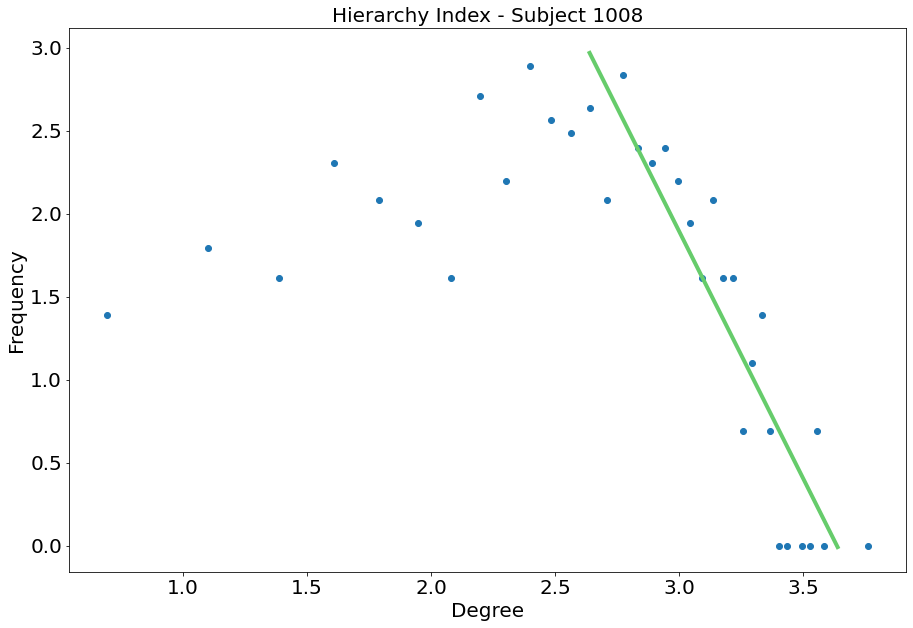

In [8]:
# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
save_bool = False # if you want to save the respective figure
plot_edges_bool = False # if you want to plot the graph's edges
save_centrality = False # if you want to save the centrality dataframe (node degree) as csv 

calculate_Partitioning = False # if you want to calculate the graph partitioning
calculate_Hierarchy = True  # if you want to calculate the hierarchy index 
calculate_RC = False  # if you want to calculate the rich club coefficient
calculate_triang = False  # if you want to calculate the triangulation

subcount = 0 # count subjects


# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")


            
# use if statements to avoid overwrite
if calculate_Partitioning:
    PartitioningDoc = pd.DataFrame()
if calculate_Hierarchy:
    HierarchyIndexDoc = pd.DataFrame()
if calculate_RC:
    RichClubDoc = pd.DataFrame()


# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                             if f.startswith(str(subject)+'_edgelist')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
            try:
                edge_list = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " edgelist!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 



    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

    # Remove the NoHit Node
    G.remove_node('NoHit')
    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)
    nodearray = np.array(G.nodes)
    
    
    # coord dict
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')

    # degree list of the graph
    degree_list = list(dict(G.degree).values())

    # --------- ANALYSIS ---------

    # --------- PARTITIONING ---------
    if calculate_Partitioning == True:     
        # ---- Step 1 ----
        
        # get laplacian matrix and its eigenvalues + eigenvectors
        laplacian_matrix = nx.laplacian_matrix(G)
        laplacian_matrix = sparse.csr_matrix.toarray(laplacian_matrix)
        # Eigenvalues and vectors
        Eigenvalue, Eigenvector = np.linalg.eig(laplacian_matrix)
        # sort Eigenvalues in ascending order and use index to sort eigenvectors
        index_array = np.argsort(Eigenvalue)
    
        # check if smallest eigenvalue is 0 (or close to 0)
        if Eigenvalue[index_array][0] < 1e-10:
            print('smallest Eigenvalue is 0')
            # check if second smallest eigenvalue is larger 0 (this means the graph is fully connected)
            if Eigenvalue[index_array][1] > 1e-10:
                print('Graph is fully connected')
                
                # create a dataframe and assign both the eigenvector sorted
                house_eig_df = pd.DataFrame()
                house_eig_df['House'] = nodearray
                house_eig_df['Eigenvector'] = Eigenvector[:,index_array[1]]
                
                
                eig_pos = house_eig_df[house_eig_df.Eigenvector >= 0]
                eig_neg = house_eig_df[house_eig_df.Eigenvector < 0]
                
                # create the subgraphs
                posG = G.subgraph(eig_pos.House)
                negG = G.subgraph(eig_neg.House)
                
                # Calculate number of edges and how many were cut
                totalEdges = G.number_of_edges()
                C1_Edges = posG.number_of_edges() 
                C2_Edges = negG.number_of_edges()
                combinedEdges = C1_Edges + C2_Edges
                Cut_Edges = totalEdges - combinedEdges
                # Calculate number of nodes
                total_nodes = G.number_of_nodes()
                C1_nodes = posG.number_of_nodes()
                C2_nodes = negG.number_of_nodes()
                # Calculate the density
                total_density = totalEdges/nchoosek(total_nodes,2)
                C1_density = C1_Edges/nchoosek(C1_nodes,2)
                C2_density = C2_Edges/nchoosek(C2_nodes,2)
                
                
                # Adding the values to the partitioning documentation dataframe
                partitioning_sub_df = pd.DataFrame()
                partitioning_sub_df.loc[0, 'Subject'] = subject
                partitioning_sub_df.loc[0, 'Eigenvalue'] = Eigenvalue[index_array][1]
                partitioning_sub_df.loc[0, 'Complete Edges'] = totalEdges
                partitioning_sub_df.loc[0, 'C1 Edges'] = C1_Edges
                partitioning_sub_df.loc[0, 'C2 Edges'] = C2_Edges
                partitioning_sub_df.loc[0, 'Cut Edges'] = Cut_Edges
                partitioning_sub_df.loc[0, 'Total Nodes'] = total_nodes
                partitioning_sub_df.loc[0, 'C1 Nodes'] = C1_nodes
                partitioning_sub_df.loc[0, 'C2 Nodes'] = C2_nodes
                partitioning_sub_df.loc[0, 'Complete Degree'] = (totalEdges*2)/total_nodes
                partitioning_sub_df.loc[0, 'C1 Degree'] = C1_Edges/C1_nodes*2
                partitioning_sub_df.loc[0, 'C2 Degree'] = C2_Edges/C2_nodes*2
                partitioning_sub_df.loc[0, 'Complete Density'] = total_density
                partitioning_sub_df.loc[0, 'C1 Density'] = C1_density
                partitioning_sub_df.loc[0, 'C2 Density'] = C2_density               

                
                PartitioningDoc = PartitioningDoc.append(partitioning_sub_df)
                
                
                
                # ------- PLOTTING ---------
                
                if Plotting_bool == True:

                    # Plotting the eigenvector 
                    
                    fig_eig = plt.figure(figsize=(10,10))
                    
                    plot_eig = house_eig_df.sort_values(by='Eigenvector').reset_index()
                    plot_eig_neg = plot_eig.Eigenvector[plot_eig.Eigenvector<0]
                    plot_eig_pos = plot_eig.Eigenvector[plot_eig.Eigenvector>=0]

                    plt.plot(plot_eig_neg, linewidth = 5, color =green)
                    plt.plot(plot_eig_pos, linewidth = 5, color =blue)

                    # settings
                    plt.xlabel('Eigenvector Entry', fontsize=fontsize)
                    plt.ylabel('Eigenvector Value', fontsize=fontsize)
                    plt.xticks(fontsize=fontsize)
                    plt.yticks(fontsize=fontsize)
                    
                    
                    # save the graph as png 
                    if save_bool == True:
                        # saving the subject info dataframe
                        try:
                            plt.savefig(GIT_GRAPH_PATH + str(subject) + "_Eigenvector.png",
                                        format="PNG",
                                        facecolor='white',
                                        transparent=False)

                            print("\tGraph PNG saved")
                        except:
                            print("\tCould not save subject " + str(subject) + " Eigenvector as PNG!")


                    # plotting the spy matrix 
                    # get the sorting pattern of the 2nd smallest eigenvector
                    sorted_adj = np.sort(Eigenvector[:,index_array[1]])
                    index = np.argsort(Eigenvector[:,index_array[1]])
                    # sort the adjacency matrix according to the eigenvector (currently not)
                    adj = sparse.csr_matrix.toarray(nx.adjacency_matrix(G))

                    fig_spy = plt.figure(figsize=(10,10))
                    #kwargs = {'color':green}
                    plt.spy(adj)#, **kwargs)
                    

                    
                    # Plotting the graph on the map 

                    # plot the map
                    fig = plt.figure(figsize=(20,15))
                    ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
                    plt.title("Graph on Map - Subject " + str(subject))
                    plt.xlim(0, 4096)
                    plt.ylim(0, 4096)
                    ax.set_frame_on(False)
                    plt.axis('off')
                    plt.imshow(white_bg_img,aspect=ax.get_aspect(),
                             extent= ax.get_xlim() + ax.get_ylim(),
                             zorder=1, alpha=0.8)

                    # Draw the graph 
                    vmin = np.min(degree_list)
                    vmax = np.max(degree_list)


                    # plotting the clusters
                    # positive cluster
                    nx.draw_networkx_nodes(posG, node_color = blue, pos=node_pos, node_size=100)
                    # negative cluster
                    nx.draw_networkx_nodes(negG, node_color = green, pos=node_pos, node_size=100)




                    if plot_edges_bool == True:
                        nx.draw_networkx_edges(G, 
                                               node_pos, 
                                               edge_color='k', 
                                               alpha=0.5, 
                                               width=1,
                                               style='dashed')


                    sm = plt.cm.ScalarMappable(cmap=parula_map, norm=plt.Normalize(vmin=vmin, vmax=vmax))
                    sm.set_array([])
                    cbar = plt.colorbar(sm)
                    cbar.ax.tick_params(labelsize=20)
                    cbar.set_label('Node Degree', size=20)
                    
                    
                    # save the graph as png 
                    if save_bool == True:
                        # saving the subject info dataframe
                        try:
                            plt.savefig(GIT_GRAPH_PATH + str(subject) + "_Cluster_Graph.png",
                                        format="PNG",
                                        facecolor='white',
                                        transparent=False)

                            print("\tGraph PNG saved")
                        except:
                            print("\tCould not save subject " + str(subject) + " Graph as PNG!")


          
            else:
                print('Graph is not fully connected')
    
    
    # --------- HIERARCHY INDEX ---------
    if calculate_Hierarchy == True: 
        # get the median degree as a reference
        median_degree = np.median(degree_list)

        # get a list of unique degree values
        UniqueDegree = np.unique(degree_list)
        UniqueDegreeMed = UniqueDegree[UniqueDegree >= median_degree]

        # get the frequency of each degree value
        DegreeFrequency = dict()

        for degree in UniqueDegree:
            DegreeFrequency[degree] = np.sum(degree_list==degree)

        DegreeFrequencyMed = np.array(list(DegreeFrequency.values()))[UniqueDegree >= median_degree]

        # do a linear fit of the log data of Unique Degree over Frequency
        linear_model=np.polyfit(np.log(UniqueDegreeMed),np.log(DegreeFrequencyMed),1)
        linear_model_fn=np.poly1d(linear_model)

        # save the hierarchy index (the slope of the fit)
        hierarchy_sub_df = pd.DataFrame()
        hierarchy_sub_df.loc[0, 'Subject'] = subject
        hierarchy_sub_df.loc[0, 'HierarchyIndex'] = -linear_model[0]

        HierarchyIndexDoc = HierarchyIndexDoc.append(hierarchy_sub_df)

        
        # ------- PLOTTING ---------
                
        if Plotting_bool == True:

            plt.figure(figsize=(15,10))
            plt.scatter(np.log(UniqueDegree),np.log(list(DegreeFrequency.values())), )

            x_s=np.arange(np.log(median_degree) ,max(np.log(UniqueDegree)+0.5))
            plt.plot(x_s, linear_model_fn(x_s),color=green, linewidth=4)

            # settings
            plt.title('Hierarchy Index - Subject ' + str(subject), fontsize=fontsize)
            plt.xlabel('Degree', fontsize=fontsize)
            plt.ylabel('Frequency', fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.yticks(fontsize=fontsize)

            if save_bool == True:
                    # saving the figure
                    try:
                        plt.savefig(GIT_GRAPH_PATH + str(subject) + "_HierarchyIndex.png",
                                    format="PNG",
                                    facecolor='white',
                                    transparent=False)
                    except:
                        print("\tCould not save subject " + str(subject) + " HierarchyIndex as PNG!")


    
    # --------- RICH CLUB COEFFICIENT ---------
    if calculate_RC == True:
        
        RichClub_sub = pd.DataFrame()    
            
        # calculate the rich club for the subject graph
        RC = nx.rich_club_coefficient(G, normalized=False, seed=1)

        # create a random graph for the rich club weighting with the same degree distribution
        edges = random_graph.sample_simple_graph(degree_list)
        randomG = nx.Graph()
        randomG = nx.from_edgelist(edges)

        # calculate the ric club for the random graph
        RC_random = nx.rich_club_coefficient(randomG, normalized=False, seed=2)
        
        RichClub_sub[str(subject)] = np.array(list(RC.values()))/np.array(list(RC_random.values()))
        #RichClub_sub = [i / j for i, j in zip(list(RC.values()), list(RC_random.values()))]
        RichClub_sub.reset_index(drop=True,inplace=True)
        #RichClubDoc = RichClubDoc.append(RichClub_sub)
        
        
        if len(RichClubDoc) != 0 and (len(RichClubDoc) < len(RichClub_sub)):
            RichClubDoc = RichClubDoc.reindex(range(max(len(RichClubDoc), len(RichClub_sub))))
               
        RichClubDoc[str(subject)] = RichClub_sub[str(subject)]
        
        
        # -------- PLOTTING ---------
        if Plotting_bool == True:
            plt.figure(figsize=(10,7))
            plt.plot(RichClub_sub[str(subject)],
                     linewidth=3,
                     color=green)

            # settings
            plt.title('Rich Club - Subject ' + str(subject), fontsize=fontsize)
            plt.xlabel('Degree', fontsize=fontsize)
            plt.ylabel('Rich Club (Real/Random)', fontsize=fontsize)
            plt.xticks(fontsize=fontsize)
            plt.yticks(fontsize=fontsize)
            plt.ylim(0.8,2)
    

            # --------- SAVING ---------
            if save_bool == True:
                # saving the figure
                try:
                    plt.savefig(GIT_GRAPH_PATH + str(subject) + "_RichClub.png",
                                format="PNG",
                                facecolor='white',
                                transparent=False)
                except:
                    print("\tCould not save subject " + str(subject) + " RichCLub as PNG!")
    

    # --------- TRIANGULATION ---------
    if calculate_triang == True: 
        pass
    
    

    
  

    

    # --------- SAVING ---------
               
               
               

    


if save_bool == True: 
    # saving the subject info dataframe
    try:
        PartitioningDoc.to_csv(GIT_GRAPH_PATH
                        + "PartitioningDoc.csv", 
                        index=False)
        
        print("Partitioning Dataframe saved")
        

        HierarchyIndexDoc.to_csv(GIT_GRAPH_PATH
                        + "HierarchyTable.csv", 
                        index=False)
        print("Hierarchy Dataframe saved")
        
        RichClubDoc.to_csv(GIT_GRAPH_PATH
                + "RichClubDoc.csv", 
                index=False)
        print("Rich Club Dataframe saved")
        
    except:
        print("\tCould not save data!")



    
print('Done')
   

## Subject Overviews


### Partitioning 

In [9]:
PartitioningDoc

,Subject,Eigenvalue,Complete Edges,C1 Edges,C2 Edges,Cut Edges,Total Nodes,C1 Nodes,C2 Nodes,Complete Degree,C1 Degree,C2 Degree,Complete Density,C1 Density,C2 Density
0,1005.0,0.476355,1304.0,469.0,713.0,122.0,238.0,105.0,133.0,10.957983,8.933333,10.721805,0.046236,0.085897,0.081226
0,1008.0,0.610672,1789.0,512.0,1114.0,163.0,241.0,90.0,151.0,14.846473,11.377778,14.754967,0.061860,0.127840,0.098366
0,1010.0,0.454180,1544.0,439.0,1004.0,101.0,240.0,93.0,147.0,12.866667,9.440860,13.659864,0.053835,0.102618,0.093561
0,1011.0,0.402088,1503.0,361.0,1043.0,99.0,242.0,85.0,157.0,12.421488,8.494118,13.286624,0.051541,0.101120,0.085171
0,1013.0,0.327121,1436.0,1009.0,355.0,72.0,240.0,163.0,77.0,11.966667,12.380368,9.220779,0.050070,0.076422,0.121326
0,1017.0,0.451723,1453.0,688.0,630.0,135.0,242.0,127.0,115.0,12.008264,10.834646,10.956522,0.049827,0.085989,0.096110
0,1021.0,0.452345,1338.0,429.0,795.0,114.0,237.0,98.0,139.0,11.291139,8.755102,11.438849,0.047844,0.090259,0.082890
0,1023.0,0.623195,1690.0,907.0,623.0,160.0,240.0,137.0,103.0,14.083333,13.240876,12.097087,0.058926,0.097359,0.118599


### Node Degree
* Calculate the following figures:
     1. Errorbar plot of all subjects
     2. Imagescale plot of all subjects over houses with ascendingly ordered degree
     3. Correlation of inter subject degree distributions 
     4. Errorbar plot of all houses

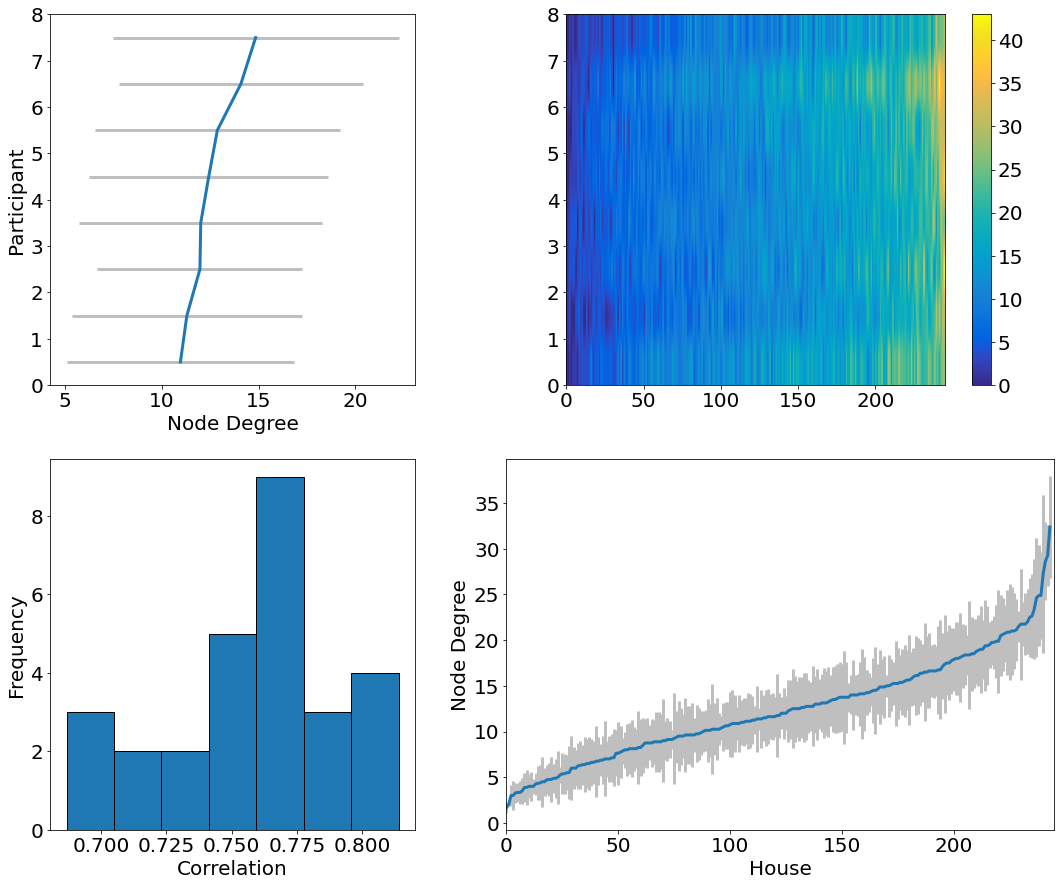

In [293]:
# open the Node degree csv file as dictionary
with open(GIT_GRAPH_PATH + 'centrality_df.csv') as f:
    try:
        centrality_df = pd.read_csv(f)
    except:
            print("\tCould not load centrality_df!")


# create a pure degree dataframe by removing mean and std values 
pure_degree = centrality_df.drop(['Mean', 'STD'], axis=1)
pure_degree = pure_degree.drop(pure_degree[(pure_degree.Subject == 'Mean') | (pure_degree.Subject == 'STD')].index)

# create lists for mean/std degree over subjects and houses 
mean_degree_subs = pure_degree.iloc[:, 1:].mean(axis=1).copy()
std_degree_subs = pure_degree.iloc[:, 1:].std(axis=1).copy()
mean_degree_houses = pure_degree.iloc[:, 1:].mean(axis=0).copy()
std_degree_houses = pure_degree.iloc[:, 1:].std(axis=0).copy()

# sort index 
sub_sort_index = np.argsort(mean_degree_subs)
house_sort_index = np.argsort(mean_degree_houses)

sorted_cent = pure_degree.iloc[:, 1:].copy()
sorted_cent.index = sub_sort_index
sorted_cent = sorted_cent[pure_degree.columns[1:][house_sort_index]]
sorted_cent.reset_index()
sorted_cent.fillna(0, inplace=True)



# calculating the correlation coefficients
correlation_matrix = pure_degree.iloc[:, 1:].T.corr().copy()
# creating a mask to get the lower diagonal of the matrix
correlation_matrix = correlation_matrix.mask(np.triu(np.ones(correlation_matrix.shape, dtype=np.bool_)))
# squeeze non nans to list 
correlation_list = np.asarray(correlation_matrix).reshape(-1)
correlation_list = correlation_list[~np.isnan(correlation_list)]

figgy = plt.figure(figsize=(18,15))
gs = gridspec.GridSpec(2, 2, width_ratios=[1, 1.5]) 

# errorbar plot 
ax1 = figgy.add_subplot(gs[0])
plt.errorbar(mean_degree_subs[sub_sort_index],
             np.arange(0.5, len(mean_degree_subs)+0.5),
             xerr=std_degree_subs[sub_sort_index],
             ecolor=grey,
             mfc=blue,
             linewidth = 3)

#plt.ylim([0, len(mean_degree_subs)+1])
plt.xlabel('Node Degree', fontsize=fontsize)
plt.ylabel('Participant', fontsize=fontsize)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)


# image scale plot
ax2 = figgy.add_subplot(gs[1], sharey = ax1)
plt.imshow(sorted_cent,
           extent=[0, np.shape(pure_degree)[1], 0, np.shape(pure_degree)[0]],
           cmap=parula_map)

plt.colorbar(shrink=1)
ax2.set_aspect(30)

# correlation histogram
ax3 = figgy.add_subplot(gs[2])
plt.hist(correlation_list, ec='k', bins=7)

plt.xlabel('Correlation', fontsize=fontsize)
plt.ylabel('Frequency', fontsize=fontsize)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)

# errorbar plot for houses 
ax4 = figgy.add_subplot(gs[3], sharex = ax2)

plt.errorbar(np.arange(0, len(mean_degree_houses)),
             mean_degree_houses[house_sort_index],
             yerr=std_degree_houses[house_sort_index],
             ecolor=grey,
             mfc=blue,
             linewidth = 3)

plt.xlabel('House', fontsize=fontsize)
plt.ylabel('Node Degree', fontsize=fontsize)
plt.rc('xtick', labelsize=fontsize) 
plt.rc('ytick', labelsize=fontsize)


### Hierarchy Index

In [10]:
HierarchyIndexDoc

,Subject,HierarchyIndex
0,1005.0,2.842830
0,1008.0,2.978061
0,1010.0,2.806976
0,1011.0,2.883846
0,1013.0,3.708688
0,1017.0,2.656091
0,1021.0,2.725497
0,1023.0,2.644072


### Rich Club Coefficient
* Requires previous saving of the Rich Club Documentation

In [12]:
RichClubDoc

,1005,1008,1010,1011,1013,1017,1021,1023
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
2,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
3,1.000000,1.000000,1.000000,1.001353,1.000000,1.000704,1.000000,1.000000
4,1.000829,1.000000,1.000000,1.001383,0.999283,1.000000,1.001609,1.001222
5,1.001789,0.998820,1.000000,1.000713,1.001508,1.000000,1.005063,1.001248
6,1.004660,1.004248,1.001453,1.005263,1.005499,1.004706,1.011680,1.001271
7,1.010288,1.008750,1.003834,1.007241,1.009950,1.007563,1.009390,1.006557
8,1.018626,1.012812,1.006809,1.008703,1.012704,1.013739,1.016211,1.003406
9,1.029491,1.017397,1.023452,1.024777,1.004065,1.022654,1.024306,1.004996


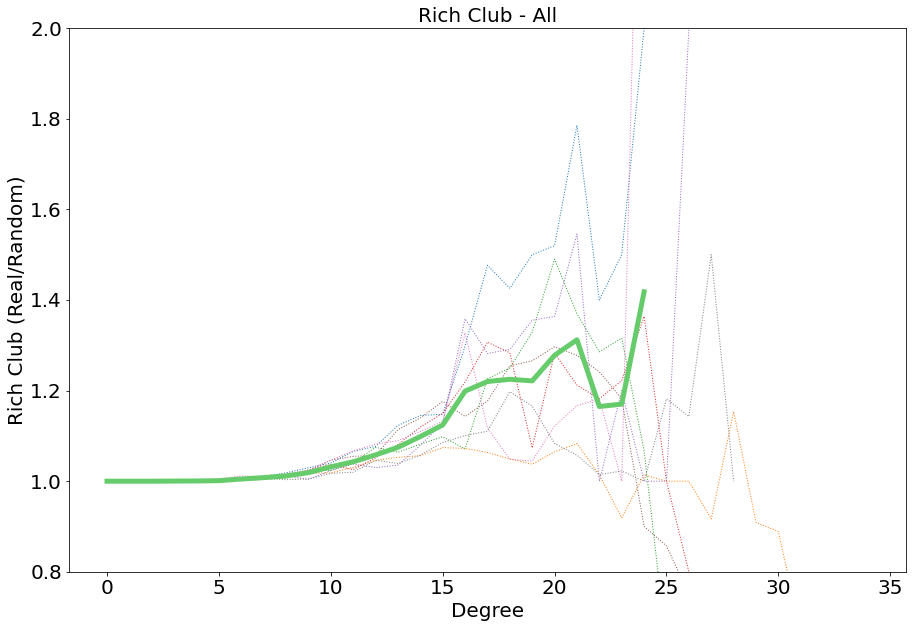

In [13]:
save_bool = True # if you want to save and overwrite 

# load the RC documentation
with open(GIT_GRAPH_PATH + 'RichClubDoc.csv') as f:
    try:
        RichClubDoc = pd.read_csv(f)
    except:
            print("\tCould not load RichClubDoc!")

            

plt.figure(figsize=(15,10))

for sub in RichClubDoc.columns:
    plt.plot(RichClubDoc[sub], linestyle=':', linewidth=1)

plt.plot(RichClubDoc.mean(axis=1), linewidth=5, color=green)    

plt.title('Rich Club - All', fontsize=fontsize)
plt.xlabel('Degree', fontsize=fontsize)
plt.ylabel('Rich Club (Real/Random)', fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.ylim(0.8,2)


if save_bool == True:
    # saving the figure
    try:
        plt.savefig(GIT_GRAPH_PATH + "RichClub_All.png",
                    format="PNG",
                    facecolor='white',
                    transparent=False)
    except:
        print("\tCould not save RichCLub_All as PNG!")



         

### Triangulation

In [4]:
# one sub

# --------- Preparation ---------
Plotting_bool = True # if you want to plot the graph
save_bool = False # if you want to save the respective figure
plot_edges_bool = False # if you want to plot the graph's edges
save_centrality = False # if you want to save the centrality dataframe (node degree) as csv 

calculate_Partitioning = False # if you want to calculate the graph partitioning
calculate_Hierarchy = True  # if you want to calculate the hierarchy index 
calculate_RC = False  # if you want to calculate the rich club coefficient
calculate_triang = False  # if you want to calculate the triangulation

subcount = 0 # count subjects


# load the city map image
white_bg_img = cv2.imread("./ressources/map_white.png")


            
# use if statements to avoid overwrite
if calculate_Partitioning:
    PartitioningDoc = pd.DataFrame()
if calculate_Hierarchy:
    HierarchyIndexDoc = pd.DataFrame()
if calculate_RC:
    RichClubDoc = pd.DataFrame()


# --------- MAIN PART ---------
# load the files 
for subject in subIDs:
    subcount +=1
    print('Subject ' + str(subject) + ' started - ' + str(subcount) + '/' + str(len(subIDs)))
    
    # get the data files according to the subject
    subject_folder = sorted([f for f in GIT_GRAPH_FOLDER 
                             if f.startswith(str(subject)+'_edgelist')], key=str.lower)

    if len(subject_folder) != 0:
        
        # open the JSON file as dictionary
        with open(GIT_GRAPH_PATH + subject_folder[0]) as f:
            try:
                edge_list = pd.read_csv(f)
            except:
                    print("\tCould not load subject " + str(subject) + " edgelist!")

    else:
        print('Subject ' + str(subject) + ' has no data file!')
        continue 



    # --------- GRAPH CREATION ---------

    # create graph from edgelist
    G = nx.Graph()
    G = nx.from_pandas_edgelist(edge_list, 'Edge1', 'Edge2')

    # Remove the NoHit Node
    G.remove_node('NoHit')
    # Setting the node coordinates of each node of the graph


    # node list
    nodelist = list(G.nodes)
    nodearray = np.array(G.nodes)
    
    
    # coord dict
    node_pos = {}

    for node in nodelist:
        # assign node coordinates
        x = houselist['transformed_collidercenter_x'][houselist.target_collider_name==node].values[0]
        y = houselist['transformed_collidercenter_y'][houselist.target_collider_name==node].values[0]
        node_pos[node] = (x,y) 

    # set the graph's node coordinates attribute
    nx.set_node_attributes(G, node_pos, 'coord')

    # degree list of the graph
    degree_list = list(dict(G.degree).values())
    
    
    
    
        
    

Subject 1008 started - 1/1


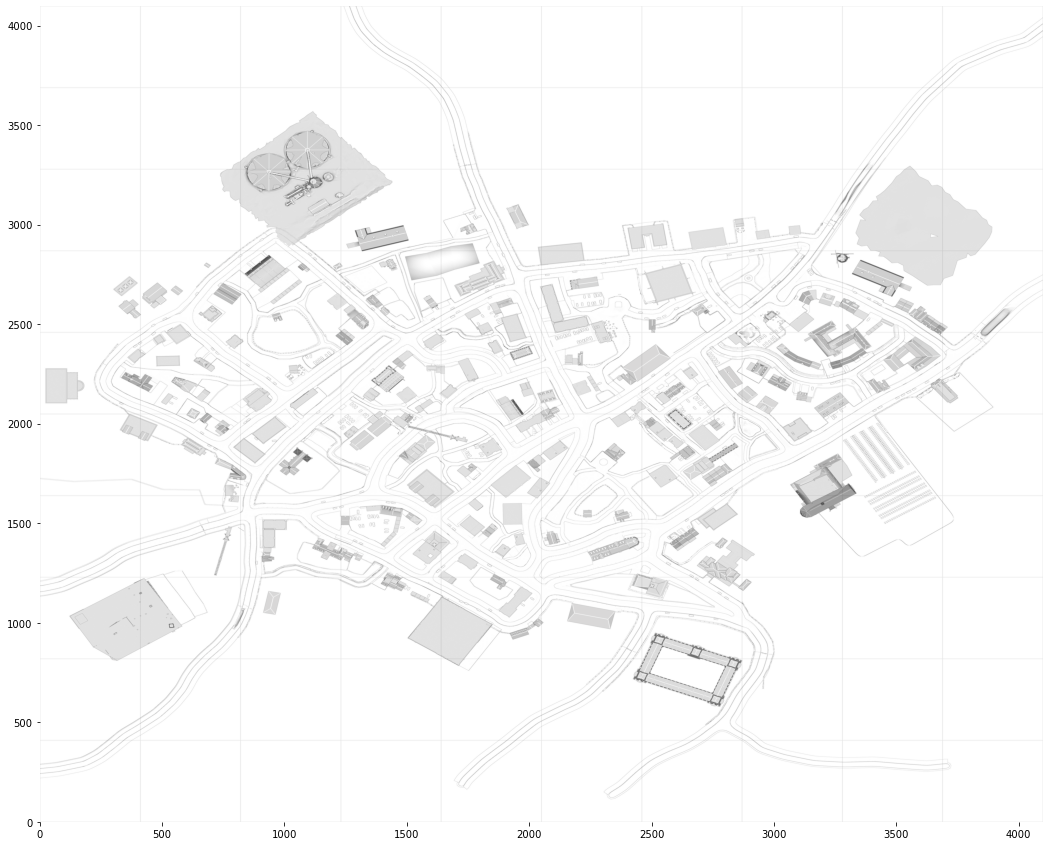

In [9]:
fig = plt.figure(figsize=(20,15))
ax = plt.subplot2grid((10, 10), (0, 0), colspan=9,rowspan=10)
plt.xlim(0, 4096)
plt.ylim(0, 4096)
ax.set_frame_on(False)
#plt.axis('off')
plt.imshow(white_bg_img,aspect=ax.get_aspect(),
         extent= ax.get_xlim() + ax.get_ylim(),
         zorder=1, alpha=0.8)

In [28]:
rows, cols, colorchannels = np.shape(white_bg_img)

EdgesRows = np.linspace(0, edges, int(edges/4))
EdgesCols = np.linspace(0, cols, int(cols/4))

